In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import os
import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from PIL import Image
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet152
from keras.layers import GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

In [ ]:
def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, [128, 128])
    img = tf.cast(img, tf.float32) / 255.0
    return img

def get_image_paths_and_labels(dirname, label):
    paths = []
    for root, _, filenames in os.walk(dirname):
        for filename in filenames:
            paths.append((os.path.join(root, filename), label))
    return paths

path_label_pairs = get_image_paths_and_labels('/content/drive/MyDrive/archive(1)/train/Non Demented', 0) + \
                   get_image_paths_and_labels('/content/drive/MyDrive/archive(1)/train/Mild Dementia', 1) + \
                   get_image_paths_and_labels('/content/drive/MyDrive/archive(1)/train/Moderate Dementia', 2) + \
                   get_image_paths_and_labels('/content/drive/MyDrive/archive(1)/train/Very mild Dementia', 3)

np.random.shuffle(path_label_pairs)
paths, labels = zip(*path_label_pairs)

In [ ]:
checkpoint_path = "model_checkpoints/cp-{epoch:04d}.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=False,
    save_freq='epoch'
)

In [ ]:
encoder = OneHotEncoder()
result = encoder.fit_transform(np.array(labels).reshape(-1, 1)).toarray()

paths = np.array(paths)
result = np.array(result)

x_train, x_test, y_train, y_test = train_test_split(paths, result, test_size=0.15, shuffle=True, random_state=42)

class_frequencies = np.sum(y_train, axis=0)

total_samples = np.sum(class_frequencies)
class_weights = {i: total_samples / freq for i, freq in enumerate(class_frequencies)}

In [ ]:
labels_mapping = {0: 'Non Demented', 1: 'Mild Dementia', 2: 'Moderate Dementia', 3: 'Very mild Dementia'}
train_labels = [labels_mapping[np.argmax(label)] for label in y_train]
train_df = pd.DataFrame({"path": x_train, "label": train_labels})

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="path",
    y_col="label",
    target_size=(128, 128),
    batch_size=5,
    class_mode='categorical',
    classes=['Non Demented', 'Mild Dementia', 'Moderate Dementia', 'Very mild Dementia'],
    shuffle=True,
    seed=42
)

Found 703 validated image filenames belonging to 4 classes.


In [ ]:
resnet152_base = ResNet152(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


for layer in resnet152_base.layers:
    layer.trainable = False


model = Sequential()
model.add(resnet152_base)
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

234698864/234698864 [==============================] - 10s 0us/step


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='Adamax', metrics=['accuracy'])



In [ ]:


early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)



In [ ]:
class PrintAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        num_epochs = self.params['epochs']
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Training Accuracy: {logs['accuracy']:.4f}")


In [ ]:
class SaveCheckpointEvery10th(tf.keras.callbacks.ModelCheckpoint):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 10 == 0:
            super().on_epoch_end(epoch, logs)

In [ ]:
num_epochs = 20

history = model.fit(
    train_data_generator,
    epochs=num_epochs,
    steps_per_epoch=len(train_data_generator),
    callbacks=[
        SaveCheckpointEvery10th(filepath=checkpoint_path, save_weights_only=True, save_best_only=False),
        early_stopping_callback,
        PrintAccuracyCallback(),
    ],
    class_weight=class_weights
)

Epoch 1/20
141/141 [==============================] - ETA: 0s - loss: 4.2239 - accuracy: 0.5747


Epoch 1/20
Training Accuracy: 0.5747
141/141 [==============================] - 190s 1s/step - loss: 4.2239 - accuracy: 0.5747
Epoch 2/20
141/141 [==============================] - ETA: 0s - loss: 4.2463 - accuracy: 0.5363


Epoch 2/20
Training Accuracy: 0.5363
141/141 [==============================] - 186s 1s/step - loss: 4.2463 - accuracy: 0.5363
Epoch 3/20
141/141 [==============================] - ETA: 0s - loss: 4.0297 - accuracy: 0.5533


Epoch 3/20
Training Accuracy: 0.5533
141/141 [==============================] - 187s 1s/step - loss: 4.0297 - accuracy: 0.5533
Epoch 4/20
141/141 [==============================] - ETA: 0s - loss: 4.1929 - accuracy: 0.5448


Epoch 4/20
Training Accuracy: 0.5448
141/141 [==============================] - 190s 1s/step - loss: 4.1929 - accuracy: 0.5448
Epoch 5/20
141/141 [==============================] - ETA: 0s - loss: 4.0444 - accuracy: 0.5533


Epoch 5/20
Training Accuracy: 0.5533
141/141 [==============================] - 186s 1s/step - loss: 4.0444 - accuracy: 0.5533
Epoch 6/20
141/141 [==============================] - ETA: 0s - loss: 4.1314 - accuracy: 0.5491


Epoch 6/20
Training Accuracy: 0.5491
141/141 [==============================] - 189s 1s/step - loss: 4.1314 - accuracy: 0.5491
Epoch 7/20
141/141 [==============================] - ETA: 0s - loss: 3.9846 - accuracy: 0.5789


Epoch 7/20
Training Accuracy: 0.5789
141/141 [==============================] - 191s 1s/step - loss: 3.9846 - accuracy: 0.5789
Epoch 8/20
141/141 [==============================] - ETA: 0s - loss: 4.1439 - accuracy: 0.5633


Epoch 8/20
Training Accuracy: 0.5633
141/141 [==============================] - 188s 1s/step - loss: 4.1439 - accuracy: 0.5633
Epoch 9/20
141/141 [==============================] - ETA: 0s - loss: 4.2122 - accuracy: 0.5448


Epoch 9/20
Training Accuracy: 0.5448
141/141 [==============================] - 185s 1s/step - loss: 4.2122 - accuracy: 0.5448
Epoch 10/20
141/141 [==============================] - ETA: 0s - loss: 3.9064 - accuracy: 0.5818


Epoch 10/20
Training Accuracy: 0.5818
141/141 [==============================] - 195s 1s/step - loss: 3.9064 - accuracy: 0.5818
Epoch 11/20
141/141 [==============================] - ETA: 0s - loss: 3.9911 - accuracy: 0.5647


Epoch 11/20
Training Accuracy: 0.5647
141/141 [==============================] - 190s 1s/step - loss: 3.9911 - accuracy: 0.5647
Epoch 12/20
141/141 [==============================] - ETA: 0s - loss: 3.9381 - accuracy: 0.5747


Epoch 12/20
Training Accuracy: 0.5747
141/141 [==============================] - 185s 1s/step - loss: 3.9381 - accuracy: 0.5747
Epoch 13/20
141/141 [==============================] - ETA: 0s - loss: 4.2000 - accuracy: 0.5462


Epoch 13/20
Training Accuracy: 0.5462
141/141 [==============================] - 188s 1s/step - loss: 4.2000 - accuracy: 0.5462
Epoch 14/20
141/141 [==============================] - ETA: 0s - loss: 3.9840 - accuracy: 0.5989


Epoch 14/20
Training Accuracy: 0.5989
141/141 [==============================] - 186s 1s/step - loss: 3.9840 - accuracy: 0.5989
Epoch 15/20
141/141 [==============================] - ETA: 0s - loss: 3.8777 - accuracy: 0.6159


Epoch 15/20
Training Accuracy: 0.6159
141/141 [==============================] - 187s 1s/step - loss: 3.8777 - accuracy: 0.6159
Epoch 16/20
141/141 [==============================] - ETA: 0s - loss: 4.0579 - accuracy: 0.5562


Epoch 16/20
Training Accuracy: 0.5562
141/141 [==============================] - 185s 1s/step - loss: 4.0579 - accuracy: 0.5562
Epoch 17/20
141/141 [==============================] - ETA: 0s - loss: 3.9838 - accuracy: 0.5491


Epoch 17/20
Training Accuracy: 0.5491
141/141 [==============================] - 184s 1s/step - loss: 3.9838 - accuracy: 0.5491
Epoch 18/20
141/141 [==============================] - ETA: 0s - loss: 3.9449 - accuracy: 0.5676


Epoch 18/20
Training Accuracy: 0.5676
141/141 [==============================] - 185s 1s/step - loss: 3.9449 - accuracy: 0.5676
Epoch 19/20
141/141 [==============================] - ETA: 0s - loss: 4.1348 - accuracy: 0.5704


Epoch 19/20
Training Accuracy: 0.5704
141/141 [==============================] - 188s 1s/step - loss: 4.1348 - accuracy: 0.5704
Epoch 20/20
141/141 [==============================] - ETA: 0s - loss: 4.3012 - accuracy: 0.5477


Epoch 20/20
Training Accuracy: 0.5477
141/141 [==============================] - 195s 1s/step - loss: 4.3012 - accuracy: 0.5477


In [ ]:
history

In [ ]:
acc=history.history['accuracy']
#val_acc=history.history['val_accuracy']
loss=history.history['loss']
#val_loss=history.history['val_loss']

In [ ]:
model.save("/content/drive/MyDrive/archive(1)/mri_cnn3.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/archive(1)/mri_cnn2.h5")
#plot_model(loaded_model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


4/4 [==============================] - 28s 6s/step


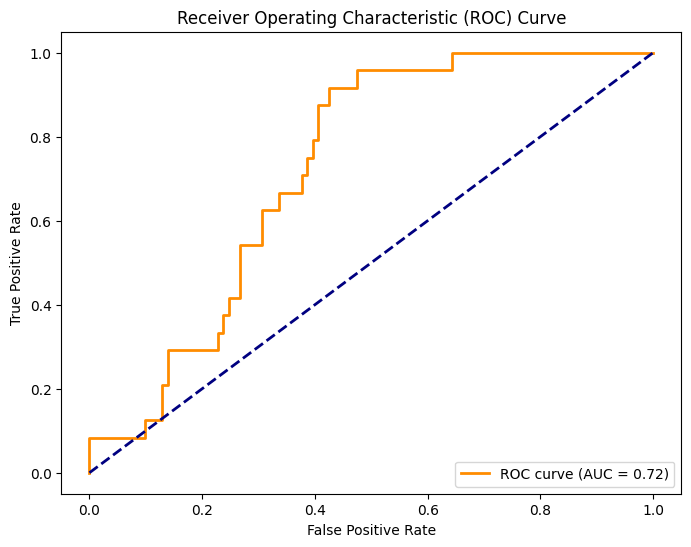

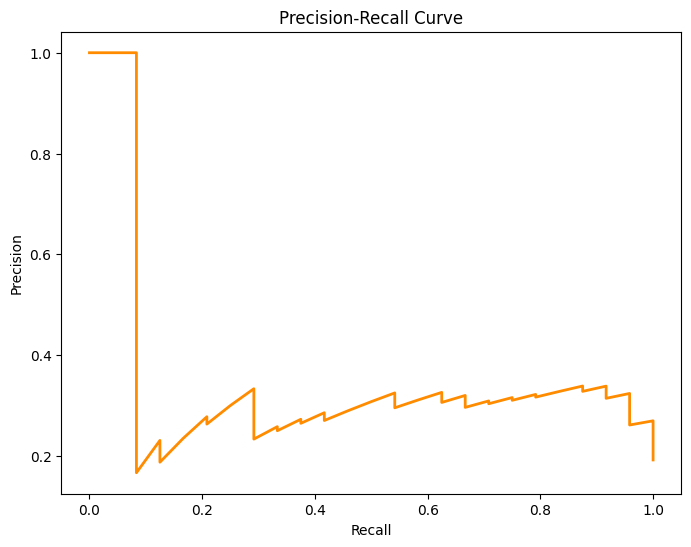

In [ ]:
# Assuming you have already defined the load_and_preprocess_image functio n
# ...

# Preprocess test images
x_test_preprocessed = np.array([load_and_preprocess_image(image_path) for image_path in x_test])

# Get model predictions for the preprocessed test images
y_pred_prob = model.predict(x_test_preprocessed)

# Assuming you are interested in binary classification for a specific class index
target_class_index = 0

# Calculate ROC curve

fpr, tpr, thresholds = roc_curve(y_test[:, target_class_index], y_pred_prob[:, target_class_index])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate Precision-Recall curve

precision, recall, thresholds = precision_recall_curve(y_test[:, target_class_index], y_pred_prob[:, target_class_index])

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
def load_and_preprocess_image(path):
    # Read the image from the file path
    img = tf.io.read_file(path)

    # Decode the image to a 3D tensor with RGB color channels
    img = tf.image.decode_image(img, channels=3)

    # Resize the image to the required dimensions (128x128)
    img = tf.image.resize(img, [128, 128])

    # Convert the pixel values to the range [0, 1]
    img = tf.cast(img, tf.float32) / 255.0

    return img
# Example usage:
image_path_to_predict ='/content/drive/MyDrive/archive(1)/test/Mild Dementia/OAS1_0268_MR1_mpr-2_119.jpg' # Provide the path to the image you want to predict'

# Load and preprocess the image
preprocessed_image = load_and_preprocess_image(image_path_to_predict)

# Expand dimensions to match the model input shape
preprocessed_image = tf.expand_dims(preprocessed_image, axis=0)

# Make predictions
predictions = loaded_model.predict(preprocessed_image)
class_names=['Non Demented', 'Mild Dementia', 'Moderate Dementia', 'Very mild Dementia']

# Assuming it's a multi-class classification problem
# You may need to adjust this depending on your specific use case
predicted_class = np.argmax(predictions[0])
predicted_label = class_names[predicted_class]
print("class:", predicted_class)
print('Predicted label:', predicted_label)

1/1 [==============================] - 0s 311ms/step
class: 1
Predicted label: Mild Dementia
